# Parameter modification and goodness-of-fit calculations

In parameterizing hydrological models, it's necesary to test multiple parameters and calculate the goodness-of-fit for each model run. Goodness-of-fit is a measure of how well the model output matches historical output so that future predictions may be made. A well-known GOF measure in Hydrology is the Nash-Sutcliffe model efficiency, from Nash & Sutcliffe's 1970 paper [River Flow Forecasting Through Conceptual Models Part I - A Discussion of Principles](./nash-sutcliffe-1970.pdf). They elegantly describe the model-fitting problem like so

> To remove subjectivity in fitting the model to the data or in determining the
parametric values, O'Donnell3) suggested automatic optimisation. This
involves successive changes of parameter values according to some pre-conceived
rule or pattern of increments which takes into account the results of
previous steps and in particular whether or not a change improved the fitting.  

The equation itself is

\begin{equation}
E = 1 - \frac{\sum_{t=1}^{T}\left(Q_o^t - Q_m^t\right)^2}{\sum_{t=1}^{T}\left(Q_o^t - \overline{Q_o}\right)^2}
\end{equation}

This may appear to be somewhat imposing, but it's quite easy to break down and understand, and to code in Python. 
If $E = 1$ this means that all variance is accounted for by the model. If $E=0$ it follows that the mean of the historical values is as good a predictor as the model itself. If $E < 0$, then the mean is a better predictor than the model.

The cell below defines the Nash-Sutcliffe goodness of fit for later use.

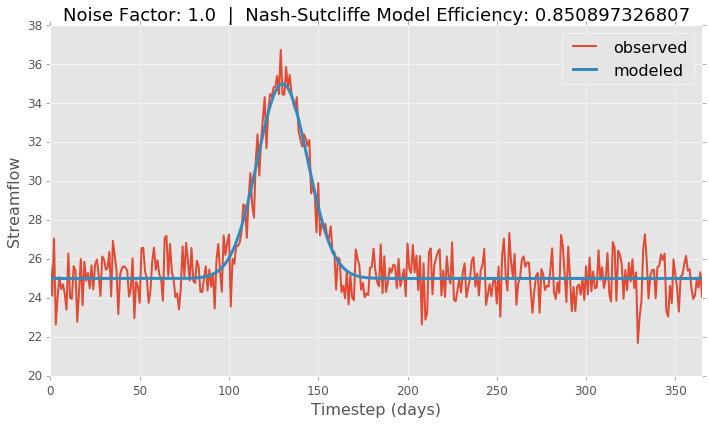

In [2]:
%matplotlib inline
from mpltools import style
style.use('ggplot')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['figure.dpi'] = 300.0
mpl.rcParams['xtick.labelsize'] = 12.0
mpl.rcParams['ytick.labelsize'] = 12.0
mpl.rcParams['axes.labelsize'] = 16.0
mpl.rcParams['axes.titlesize'] = 18.0
mpl.rcParams['legend.fontsize'] = 16.0

import numpy as np
import matplotlib.pyplot as plt

def nash_sutcliffe(observed, modeled):
    """
    Calculates the Nash-Sutcliffe Goodness-of-fit
    
    Arguments:
        observed (numpy.ndarray): historic observational data
        modeled (numpy.ndarray): 
    """
    numerator = sum((observed - modeled)**2)
    denominator = sum((observed - np.mean(observed))**2)
    
    return 1 - (numerator/denominator)

# Exampe use

# add noise to the observations; the more noise, the poorer the fit
# corresponds to amplitude of added Gaussian noise
peak_streamflow_amplitude = 10.0
peak_streamflow_day = 130
peak_streamflow_x = 0.05 * peak_streamflow_day
base_streamflow = 25.0
noise_factor = 1.0

x = np.arange(0, 18.5, 0.05)
q_obs = base_streamflow + \
        (peak_streamflow_amplitude*np.exp(-((x - peak_streamflow_x)**2)) + \
        noise_factor*np.random.normal(size=len(x)))
    
q_model = base_streamflow + peak_streamflow_amplitude*np.exp(-((x - peak_streamflow_x)**2))

ns = nash_sutcliffe(q_obs, q_model)

plt.plot(q_obs, lw=2.0, label='observed')
plt.plot(q_model, lw=3.0, label='modeled')
plt.ylabel('Streamflow')
plt.xlabel('Timestep (days)')

plt.xlim([0, 365])
plt.legend()
plt.title('Noise Factor: {0}  |  Nash-Sutcliffe Model Efficiency: {1}'.format(noise_factor, ns))

## Scale with many scale factors and two parameters

Parameterization is the process of finding the appropriate parameters to get the model to most closely match the observations. We will now create sixteen scenarios, then run PRMS on all of them. We will use the power of the Virtual Watershed modeling server to run all sixteen "asynchronously", meaning that we don't have to wait for one scenario to be done for the next to run. As computing resources become available, the model server runs all requests it receives.

I originally ran the experiment with five scale factors, but that has been commented out so if someone runs this fresh the run will only take 9/25 of the time it would otherwise have taken.

In [ ]:
# load each statsvar output into a dictionary entry as a series, keyed by output dir name
import os
from xarray import open_dataset

output_dirs = glob.glob('*-output')
print output_dirs
modeled_flows = {
    d: open_dataset(os.path.join(d, 'statsvar.nc')).sub_cfs_1.to_masked_array()
    for d in output_dirs
}
# calculate Nash-Sutcliffe for each one
d = open_dataset('data/data.nc')
q_observed = d.runoff_3.to_masked_array()
t = d.time
d.close()
nash_sutcliffe_vals = {
    d: nash_sutcliffe(q_observed, modeled_flow)
    for d, modeled_flow in modeled_flows.iteritems()
}

# matshow the result with scale values on each axis
idx_lookup = {'0.8': 0, '0.9': 1, '1.0': 2, '1.1': 3, '1.2': 4}
nash_sutcliffe_mat = np.zeros((5,5))
for d, ns in nash_sutcliffe_vals.iteritems():
    dspl = d.split('_')
    jh_factor = dspl[1]
    rad_factor = dspl[-1].split('-')[0]
    coord = (idx_lookup[jh_factor], idx_lookup[rad_factor])
    nash_sutcliffe_mat[coord] = ns

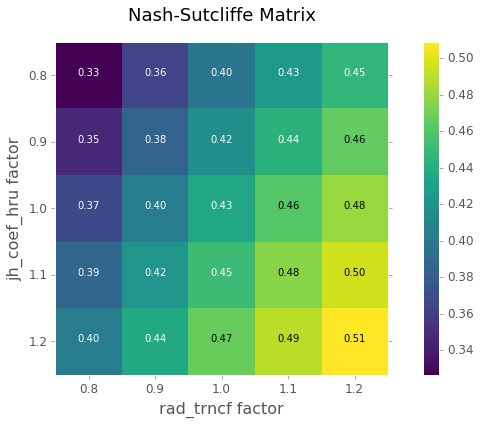

In [50]:
import itertools
fig, ax = plt.subplots()

cax = ax.matshow(nash_sutcliffe_mat, cmap='viridis')
tix = [0.8, 0.9, 1.0, 1.1, 1.2]
plt.xticks(range(5), tix)
plt.yticks(range(5), tix)


ax.xaxis.set_ticks_position('bottom')
plt.ylabel('jh_coef_hru factor')
plt.xlabel('rad_trncf factor')

for i, j in itertools.product(range(5), range(5)):
    plt.text(j, i, "%.2f" % nash_sutcliffe_mat[i, j],
             horizontalalignment="center", 
             color="w" if nash_sutcliffe_mat[i, j] < .46 else "k")

plt.title('Nash-Sutcliffe Matrix')
plt.grid(b=False)
cbar = fig.colorbar(cax)

In [48]:
# spot check to make sure our indexing was correct
print nash_sutcliffe_vals['jh_1.2_rad_1.2-output']
print nash_sutcliffe_vals['jh_1.1_rad_1.2-output']
print nash_sutcliffe_vals['jh_1.2_rad_1.1-output']
print nash_sutcliffe_vals['jh_1.0_rad_1.0-output']

0.508706379829
0.49564468608
0.48998174195
0.434923028353


In [ ]:
# as a further demo, plot five slices across jh coefficient with five plots of varying rad_trncf

In [16]:
import os
from capstone_util import create_prms_scenario_inputs, scale_params_fun_generator

#scale_factors = [0.8, 0.9, 1.0, 1.1, 1.2]
#scale_factors = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

scale_factors = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
scale_pairs = [(s1, s2) for s1 in scale_factors for s2 in scale_factors]

os.mkdir('data/scenarios/100grid-jh-rad')

In [17]:
len(scale_factors)**2

100

In [18]:
for jh_factor, rad_trncf_factor in scale_pairs:

    param_mod_fun = scale_params_fun_generator(jh_coef_hru=jh_factor, rad_trncf=rad_trncf_factor)

    create_prms_scenario_inputs('data/data.nc', 'data/parameter.nc', 'data/incline_village.control', 
                                'data/scenarios/100grid-jh-rad/jh_{}_rad_{}'.format(jh_factor, rad_trncf_factor), 
                                param_mod_fun=param_mod_fun)

In [19]:
import os
import glob
scenario_dirs = [d for d in glob.glob('data/scenarios/100grid-jh-rad/*') if os.path.isdir(d) and 'output' not in d]

print scenario_dirs

['data/scenarios/100grid-jh-rad/jh_1.1_rad_1.1', 'data/scenarios/100grid-jh-rad/jh_1.1_rad_1.2', 'data/scenarios/100grid-jh-rad/jh_1.1_rad_1.3', 'data/scenarios/100grid-jh-rad/jh_1.1_rad_1.4', 'data/scenarios/100grid-jh-rad/jh_1.1_rad_1.5', 'data/scenarios/100grid-jh-rad/jh_1.1_rad_1.6', 'data/scenarios/100grid-jh-rad/jh_1.1_rad_1.7', 'data/scenarios/100grid-jh-rad/jh_1.1_rad_1.8', 'data/scenarios/100grid-jh-rad/jh_1.1_rad_1.9', 'data/scenarios/100grid-jh-rad/jh_1.1_rad_2.0', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_1.1', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_1.2', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_1.3', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_1.4', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_1.5', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_1.6', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_1.7', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_1.8', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_1.9', 'data/scenarios/100grid-jh-rad/jh_1.2_rad_2.0', 'data/scenarios/100grid-jh-rad/jh_1.3_r

In [20]:
from capstone_util import run_many_prms
# run_many_prms automatically creates the output directories and names each model run

In [13]:
from jwt import TOKEN, PRODUCTION_TOKEN
token = PRODUCTION_TOKEN
#token = TOKEN
run_many_prms(scenario_dirs, token)  #, auth_host='https://auth-test.virtualwatershed.org/api', 
     #              model_host='https://model-test.virtualwatershed.org/api')

uploading data for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.7
uploading param for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.7
uploading control for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.7
starting model run for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.7 mr.id 211
uploading data for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.8
uploading param for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.8
uploading control for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.8
starting model run for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.8 mr.id 212
uploading data for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.9
uploading param for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.9
uploading control for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.9
starting model run for input dir data/scenarios/fullgrid-jh-rad/jh_0.7_rad_0.9 mr.id 213
uploading data for input dir data/scenarios/fu

KeyboardInterrupt: 

In [4]:
run_many_lookup = {94: 'FINISHED', 95: 'FINISHED', 96: 'FINISHED', 97: 'FINISHED', 98: 'FINISHED', 99: 'FINISHED', 100: 'FINISHED', 101: 'FINISHED', 102: 'FINISHED', 103: 'FINISHED', 104: 'FINISHED', 105: 'FINISHED', 106: 'FINISHED', 107: 'FINISHED', 108: 'FINISHED', 109: 'FINISHED', 110: 'FINISHED', 111: 'FINISHED', 112: 'FINISHED', 113: 'FINISHED', 114: 'FINISHED', 115: 'FINISHED', 116: 'FINISHED', 117: 'FINISHED', 118: 'FINISHED', 119: 'FINISHED', 120: 'FINISHED', 121: 'FINISHED', 122: 'FINISHED', 123: 'FINISHED', 124: 'FINISHED', 125: 'FINISHED', 126: 'FINISHED', 127: 'FINISHED', 128: 'FINISHED', 129: 'FINISHED', 130: 'FINISHED', 131: 'FINISHED', 132: 'FINISHED', 133: 'FINISHED', 134: 'FINISHED', 135: 'FINISHED', 136: 'FINISHED', 137: 'FINISHED', 138: 'FINISHED', 139: 'FINISHED', 140: 'FINISHED', 141: 'FINISHED', 142: 'FINISHED', 143: 'FINISHED', 144: 'FINISHED', 145: 'FINISHED', 146: 'FINISHED', 147: 'QUEUED', 148: 'FINISHED', 149: 'FINISHED', 150: 'QUEUED', 151: 'QUEUED', 152: 'FINISHED', 153: 'FINISHED', 154: 'FINISHED', 155: 'FINISHED', 156: 'FINISHED', 157: 'FINISHED', 158: 'FINISHED', 159: 'QUEUED', 160: 'FINISHED', 161: 'QUEUED', 162: 'QUEUED', 163: 'FINISHED', 164: 'FINISHED', 165: 'FINISHED', 166: 'FINISHED', 167: 'FINISHED', 168: 'QUEUED', 169: 'QUEUED', 170: 'QUEUED', 171: 'QUEUED', 172: 'FINISHED', 173: 'FINISHED', 174: 'FINISHED', 175: 'FINISHED', 176: 'FINISHED', 177: 'FINISHED', 178: 'FINISHED', 179: 'QUEUED', 180: 'FINISHED', 181: 'FINISHED', 182: 'FINISHED', 183: 'FINISHED', 184: 'FINISHED', 185: 'FINISHED', 186: 'FINISHED', 187: 'FINISHED', 188: 'QUEUED', 189: 'QUEUED', 190: 'FINISHED', 191: 'FINISHED', 192: 'FINISHED', 193: 'FINISHED'}

In [60]:
rerun_ids = [k for k, v in d.iteritems() if v == 'QUEUED']
print rerun_ids

[147, 150, 151, 159, 161, 162, 168, 169, 170, 171, 179, 188, 189]


In [65]:
len(rerun_ids)

13

In [72]:
from client.model_client.client import ModelApiClient
from client.swagger_client.apis import DefaultApi

cl = ModelApiClient(TOKEN, 'https://auth-test.virtualwatershed.org/api', 'https://model-test.virtualwatershed.org/api')
api = DefaultApi(cl)

rerun_dirs = [
    api.get_modelrun_by_id(mr_id).title.replace('-output','') for mr_id in rerun_ids
]

In [73]:
print rerun_dirs

['wider-jh_1.6_rad_1.4', 'wider-jh_1.6_rad_1.7', 'wider-jh_1.6_rad_1.8', 'wider-jh_1.7_rad_1.6', 'wider-jh_1.7_rad_1.8', 'wider-jh_1.7_rad_1.9', 'wider-jh_1.8_rad_1.5', 'wider-jh_1.8_rad_1.6', 'wider-jh_1.8_rad_1.7', 'wider-jh_1.8_rad_1.8', 'wider-jh_1.9_rad_1.6', 'wider-jh_2.0_rad_1.5', 'wider-jh_2.0_rad_1.6']


In [74]:
run_many_prms(rerun_dirs, TOKEN)

all runs finished, downloading results
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
Request to server timed out!
all outputs have been downloaded
list of modelruns run: [196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209]


In [6]:
# download many because for some reason a lot of them didn't download... 
# still problems with workers I suppose
finished_ids_to_dl = [k for k, v in run_many_lookup.iteritems() if v == 'FINISHED']

print len(finished_ids_to_dl)
#download_many_outputs(ids_to_dl, TOKEN)

87


In [7]:
# turned out that taking the last resource broke, so we have to re-download all just because it seems many
# did not download statsvar (at least three, don't want to check more, just do it right)

ids_to_dl = [196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209] + finished_ids_to_dl
print 'number of ids to dl: ' + str(len(ids_to_dl))
print ids_to_dl

number of ids to dl: 100
[196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 152, 153, 154, 155, 156, 157, 158, 160, 163, 164, 165, 166, 167, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 190, 191, 192, 193]


In [9]:
from capstone_util import download_many_outputs
from jwt import TOKEN
download_many_outputs(ids_to_dl, TOKEN)

In [ ]:
# load each statsvar output into a dictionary entry as a series, keyed by output dir name
import os
from xarray import open_dataset

output_dirs = glob.glob('wider-*-output')
#print output_dirs

modeled_flows = {}
for d in output_dirs:
    try:
        modeled_flows.update({d: open_dataset(os.path.join(d, 'statsvar.nc')).sub_cfs_1.to_masked_array()})
    except Exception as e:
        print d
        raise e
        
#modeled_flows = {
 #   d: open_dataset(os.path.join(d, 'statsvar.nc')).sub_cfs_1.to_masked_array()
#   for d in output_dirs
#}
# calculate Nash-Sutcliffe for each one
d = open_dataset('data/data.nc')
q_observed = d.runoff_3.to_masked_array()
t = d.time
d.close()
nash_sutcliffe_vals = {
    d: nash_sutcliffe(q_observed, modeled_flow)
    for d, modeled_flow in modeled_flows.iteritems()
}

In [20]:
# matshow the result with scale values on each axis
idx_lookup = {'0.8': 0, '0.9': 1, '1.0': 2, '1.1': 3, '1.2': 4}
idx_lookup = {'{0:.1f}'.format(1.1 + idx*.1): idx for idx in range(10)}
print idx_lookup

{'1.4': 3, '1.5': 4, '1.6': 5, '1.7': 6, '1.1': 0, '1.2': 1, '1.3': 2, '1.8': 7, '1.9': 8, '2.0': 9}


In [22]:
nash_sutcliffe_mat = np.zeros((10,10))
for d, ns in nash_sutcliffe_vals.iteritems():
    dspl = d.split('_')
    jh_factor = dspl[1]
    rad_factor = dspl[-1].split('-')[0]
    coord = (idx_lookup[jh_factor], idx_lookup[rad_factor])
    nash_sutcliffe_mat[coord] = ns

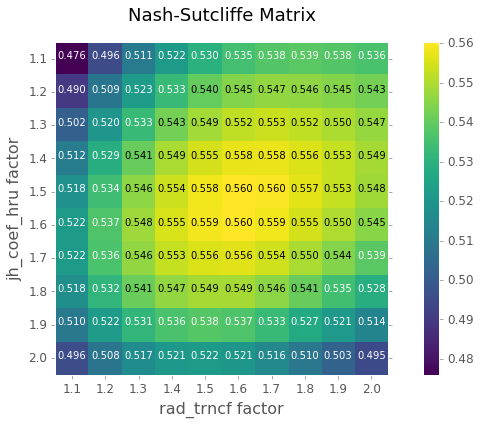

In [27]:
import itertools
fig, ax = plt.subplots()

cax = ax.matshow(nash_sutcliffe_mat, cmap='viridis')
tix = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
plt.xticks(range(10), tix)
plt.yticks(range(10), tix)


ax.xaxis.set_ticks_position('bottom')
plt.ylabel('jh_coef_hru factor')
plt.xlabel('rad_trncf factor')

for i, j in itertools.product(range(10), range(10)):
    plt.text(j, i, "%.3f" % nash_sutcliffe_mat[i, j],
             horizontalalignment="center", 
             color="w" if nash_sutcliffe_mat[i, j] < .54 else "k")

plt.title('Nash-Sutcliffe Matrix')
plt.grid(b=False)
cbar = fig.colorbar(cax)